In [1]:
import os, pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import numpy as np
import random
import seaborn as sns
from scipy.stats import shapiro, probplot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\artge\.conda\envs\mi-comp-3-11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

DATASET_ID = "minahilfatima12328/car-sales-info"
path = kagglehub.dataset_download(DATASET_ID)

print("Pobrano do:", path)
print("Pliki w folderze:", os.listdir(path))

df = pd.read_csv(os.path.join(path, "car_sales_data.csv"))
df.head()

Pobrano do: C:\Users\artge\.cache\kagglehub\datasets\minahilfatima12328\car-sales-info\versions\1
Pliki w folderze: ['car_sales_data.csv']


,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price
0,Ford,Fiesta,1.0,Petrol,2002,127300,3074
1,Porsche,718 Cayman,4.0,Petrol,2016,57850,49704
2,Ford,Mondeo,1.6,Diesel,2014,39190,24072
3,Toyota,RAV4,1.8,Hybrid,1988,210814,1705
4,VW,Polo,1.0,Petrol,2006,127869,4101


In [3]:
import pandas as pd
import numpy as np
import random

def psuj_dataset(df: pd.DataFrame) -> pd.DataFrame:
    seed = 42
    np.random.seed(seed)
    random.seed(seed)

    df_zepsuty = df.copy()

    # 1. BRAKUJĄCE DANE - różne wzorce
    numeric_cols = df_zepsuty.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_zepsuty.select_dtypes(include=['object', 'category']).columns.tolist()

    if len(numeric_cols) > 0:
        # MCAR - losowe braki w kolumnie numerycznej
        col_mcar = random.choice(numeric_cols)
        mask_mcar = np.random.random(len(df_zepsuty)) < 0.15
        df_zepsuty.loc[mask_mcar, col_mcar] = np.nan

        # MAR - braki zależne od innej zmiennej
        if len(numeric_cols) > 1:
            col_mar = random.choice([c for c in numeric_cols if c != col_mcar])
            threshold = df_zepsuty[col_mcar].quantile(0.7) if not df_zepsuty[col_mcar].isna().all() else 0
            mask_mar = (df_zepsuty[col_mcar] > threshold) & (np.random.random(len(df_zepsuty)) < 0.25)
            df_zepsuty.loc[mask_mar, col_mar] = np.nan

        # Kolumna z >60% braków do usunięcia
        if len(numeric_cols) > 2:
            col_duzo_brakow = random.choice([c for c in numeric_cols if c not in [col_mcar, col_mar] if 'col_mar' in locals()])
            mask_duzo = np.random.random(len(df_zepsuty)) < 0.65
            df_zepsuty.loc[mask_duzo, col_duzo_brakow] = np.nan

    if len(categorical_cols) > 0:
        # MNAR - braki w kategorycznej
        col_mnar = random.choice(categorical_cols)
        unique_vals = df_zepsuty[col_mnar].dropna().unique()
        if len(unique_vals) > 1:
            # Braki głównie w jednej kategorii
            target_val = random.choice(unique_vals)
            mask_mnar = (df_zepsuty[col_mnar] == target_val) & (np.random.random(len(df_zepsuty)) < 0.30)
            df_zepsuty.loc[mask_mnar, col_mnar] = np.nan

    # 2. DUPLIKATY
    n_duplicates = int(len(df_zepsuty) * 0.08)  # 8% duplikatów
    if n_duplicates > 0:
        duplicate_indices = np.random.choice(df_zepsuty.index, size=n_duplicates, replace=True)
        df_duplicates = df_zepsuty.loc[duplicate_indices].copy()
        df_zepsuty = pd.concat([df_zepsuty, df_duplicates], ignore_index=True)

    # 3. OUTLIERY
    if len(numeric_cols) > 0:
        for i, col in enumerate(numeric_cols[:min(3, len(numeric_cols))]):
            if df_zepsuty[col].notna().sum() > 0:
                # Różne typy outlierów
                n_outliers = int(len(df_zepsuty) * 0.03)
                outlier_indices = np.random.choice(df_zepsuty.index, size=n_outliers, replace=False)

                mean_val = df_zepsuty[col].mean()
                std_val = df_zepsuty[col].std()

                if i % 3 == 0:
                    # Ekstremalne wartości górne
                    df_zepsuty.loc[outlier_indices, col] = mean_val + (4 + np.random.random(n_outliers) * 3) * std_val
                elif i % 3 == 1:
                    # Ekstremalne wartości dolne
                    df_zepsuty.loc[outlier_indices, col] = mean_val - (4 + np.random.random(n_outliers) * 3) * std_val
                else:
                    # Mix górne i dolne
                    half = n_outliers // 2
                    df_zepsuty.loc[outlier_indices[:half], col] = mean_val + (4 + np.random.random(half) * 2) * std_val
                    df_zepsuty.loc[outlier_indices[half:], col] = mean_val - (4 + np.random.random(n_outliers-half) * 2) * std_val

    # 4. NIESPÓJNOŚCI W DANYCH
    if len(categorical_cols) > 0:
        col_niespojnosc = random.choice(categorical_cols)
        unique_vals = df_zepsuty[col_niespojnosc].dropna().unique()

        if len(unique_vals) > 0:
            # Różne warianty tej samej wartości (whitespace, case)
            n_niespojnosci = int(len(df_zepsuty) * 0.05)
            niespojnosc_indices = np.random.choice(df_zepsuty[df_zepsuty[col_niespojnosc].notna()].index,
                                                   size=min(n_niespojnosci, df_zepsuty[col_niespojnosc].notna().sum()),
                                                   replace=False)

            for idx in niespojnosc_indices:
                val = str(df_zepsuty.loc[idx, col_niespojnosc])
                # Losowy wybór problemu
                problem = random.choice(['lowercase', 'uppercase', 'whitespace', 'typo'])

                if problem == 'lowercase':
                    df_zepsuty.loc[idx, col_niespojnosc] = val.lower()
                elif problem == 'uppercase':
                    df_zepsuty.loc[idx, col_niespojnosc] = val.upper()
                elif problem == 'whitespace':
                    df_zepsuty.loc[idx, col_niespojnosc] = f"  {val}  "
                elif problem == 'typo' and len(val) > 2:
                    # Zamień losową literę
                    pos = random.randint(0, len(val)-1)
                    val_list = list(val)
                    val_list[pos] = random.choice('abcdefghijklmnopqrstuvwxyz')
                    df_zepsuty.loc[idx, col_niespojnosc] = ''.join(val_list)

    # 5. WARTOŚCI POZA SENSOWNYM ZAKRESEM
    if len(numeric_cols) > 0:
        col_nonsense = random.choice([c for c in numeric_cols if c != col_mcar])
        nonsense_indices = np.random.choice(df_zepsuty.index, size=int(len(df_zepsuty) * 0.02), replace=False)

        # Np. ujemne wartości gdzie powinny być dodatnie
        if df_zepsuty[col_nonsense].min() >= 0:
            df_zepsuty.loc[nonsense_indices, col_nonsense] = -abs(df_zepsuty.loc[nonsense_indices, col_nonsense])
        else:
            # Lub bardzo nietypowe wartości
            df_zepsuty.loc[nonsense_indices, col_nonsense] = df_zepsuty[col_nonsense].max() * 100

    # 6. PROBLEMY Z MULTIKOLINEARNOŚCIĄ - stwórz skorelowane kolumny
    if len(numeric_cols) >= 2:
        base_col = random.choice(numeric_cols)
        new_col_name = f"{base_col}_correlated"

        # Stwórz kolumnę silnie skorelowaną (r > 0.9)
        noise = np.random.normal(0, df_zepsuty[base_col].std() * 0.1, len(df_zepsuty))
        df_zepsuty[new_col_name] = df_zepsuty[base_col] * 1.5 + noise + 10

    # Wymieszaj kolejność wierszy
    df_zepsuty = df_zepsuty.sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_zepsuty

In [4]:
df_zepsuty = psuj_dataset(df)
df_zepsuty

C:\Users\artge\AppData\Local\Temp\ipykernel_15696\3364987260.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[418498.3028628  454875.93499023 432525.66737307 451843.55446177
 508198.18540611 491825.31122926 495014.35674099 513372.71097628
 459885.30709975 453551.53132462 531668.57522421 474777.42392428
 509192.81005971 433182.30184708 463473.63834803 498371.96231444
 462760.20846983 447469.01493754 532128.7529355  484250.16683852
 417915.94937764 442823.25247285 534011.24227962 436976.01255639
 515473.72978977 500534.1764152  497208.92278012 499457.22969846
 399598.3039123  439601.64106643 508190.99317451 489115.32859293
 481418.01026674 469220.70940094 498063.98071055 503274.40519729
 531740.51407829 518301.83457447 505877.72108453 490626.06566709
 429440.6951185  421766.18494762 526607.83871943 449241.35996089
 475782.22787963 517124.17652813 488648.52929297 449444.69669444
 467030.78456057 467835

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Price,Mileage_correlated
0,Toyota,Yaris,1.4,Petrol,2002.0,459833.184564,NaN,637570.440019
1,poyota,RAV4,NaN,Petrol,1999.0,214133.000000,NaN,-569253.351968
2,VW,Golf,1.8,Diesel,2001.0,152278.000000,4039.0,57865.811950
3,BMW,X3,2.4,Diesel,2007.0,182103.000000,NaN,153502.575227
4,Ford,Fiesta,1.2,Petrol,1997.0,222433.000000,NaN,776100.462805
...,...,...,...,...,...,...,...,...
53995,Toyota,Yaris,1.2,Hybrid,1984.0,279567.000000,370.0,-695797.649987
53996,VW,Golf,1.2,Diesel,2010.0,108027.000000,8507.0,-131861.732144
53997,VW,Passat,2.0,Diesel,2016.0,72963.000000,26206.0,454419.695064
53998,BMW,X3,2.4,Diesel,1988.0,275595.000000,NaN,-40836.530683


In [5]:
df_zepsuty.info()

num_cols = df_zepsuty.select_dtypes(include=['number']).columns.tolist()
cat_cols = df_zepsuty.select_dtypes(exclude=['number']).columns.tolist()
date_cols = df_zepsuty.select_dtypes(include=['datetime', 'datetimetz']).columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54000 entries, 0 to 53999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         53100 non-null  object 
 1   Model                54000 non-null  object 
 2   Engine size          46114 non-null  float64
 3   Fuel type            54000 non-null  object 
 4   Year of manufacture  52064 non-null  float64
 5   Mileage              54000 non-null  float64
 6   Price                19020 non-null  float64
 7   Mileage_correlated   54000 non-null  float64
dtypes: float64(5), object(3)
memory usage: 3.3+ MB


In [6]:
print("Statystyki opsiowe kolumn numerycznych")
display(df_zepsuty.describe().T)
print("Statystyki opsiowe kolumn kategorycznych")
display(df_zepsuty.describe(include=["object"]).T)

Statystyki opsiowe kolumn numerycznych


,count,mean,std,min,25%,50%,75%,max
Engine size,46114.0,1.918316e+00,1.049233e+00,1.000000e+00,1.400000,1.600000,2.00000,6.945603e+00
Year of manufacture,52064.0,2.002565e+03,1.329031e+01,1.936734e+03,1995.000000,2004.000000,2012.00000,2.022000e+03
Mileage,54000.0,1.195037e+06,7.578343e+06,-3.172479e+05,53960.000000,102974.000000,165437.75000,5.423891e+07
Price,19020.0,1.405721e+04,1.676863e+04,1.030000e+02,3115.000000,8236.500000,19154.25000,1.680010e+05
Mileage_correlated,54000.0,1.795962e+06,1.139100e+07,-2.953832e+06,-334379.152956,196156.632064,730851.08754,8.395282e+07


Statystyki opsiowe kolumn kategorycznych


,count,unique,top,freq
Manufacturer,53100,271,VW,15702
Model,54000,15,Mondeo,5461
Fuel type,54000,3,Petrol,27570


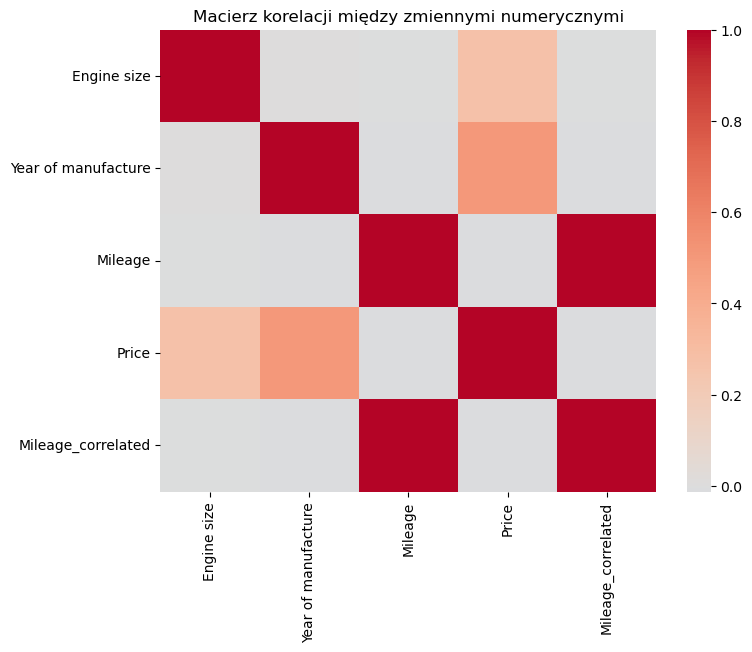

In [7]:
corr = df_zepsuty[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Macierz korelacji między zmiennymi numerycznymi")
plt.show()

In [8]:
TARGET_COL = "Price"

#korelacja numerycznych zmiennych z targetem
corr_target = df_zepsuty[num_cols].corrwith(df_zepsuty[TARGET_COL]).sort_values(ascending=False)
corr_target

Price                  1.000000
Year of manufacture    0.503768
Engine size            0.271013
Mileage_correlated    -0.011466
Mileage               -0.011865
dtype: float64

In [9]:
#Analiza korelacji par zmiennych
# Jeśli dwie zmienne numeryczne mają korelację > 0.8 lub < -0.8, to sygnał potencjalnej multikolinearnościi
corr_matrix = df_zepsuty[num_cols].corr(numeric_only=True)

high_corr = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr.columns = ["Feature_1", "Feature_2", "Correlation"]
high_corr = high_corr[high_corr["Correlation"].abs() > 0.8]

high_corr


,Feature_1,Feature_2,Correlation
8,Mileage,Mileage_correlated,0.997784


In [10]:
#skaźnik VIF (Variance Inflation Factor)

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Dane numeryczne (bez targetu)
X = df_zepsuty[num_cols].drop(columns=[TARGET_COL], errors='ignore').dropna()

# Standaryzacja
X_scaled = StandardScaler().fit_transform(X)

# Obliczenie VIF
vif_df = pd.DataFrame({
    "Feature": X.columns,
    "VIF": [variance_inflation_factor(X_scaled, i) for i in range(X.shape[1])]
}).sort_values(by="VIF", ascending=False)

vif_df

,Feature,VIF
3,Mileage_correlated,227.234860
2,Mileage,227.233530
1,Year of manufacture,1.000107
0,Engine size,1.000040


In [11]:
#1.2. Analiza brakujących danych i duplikatów:

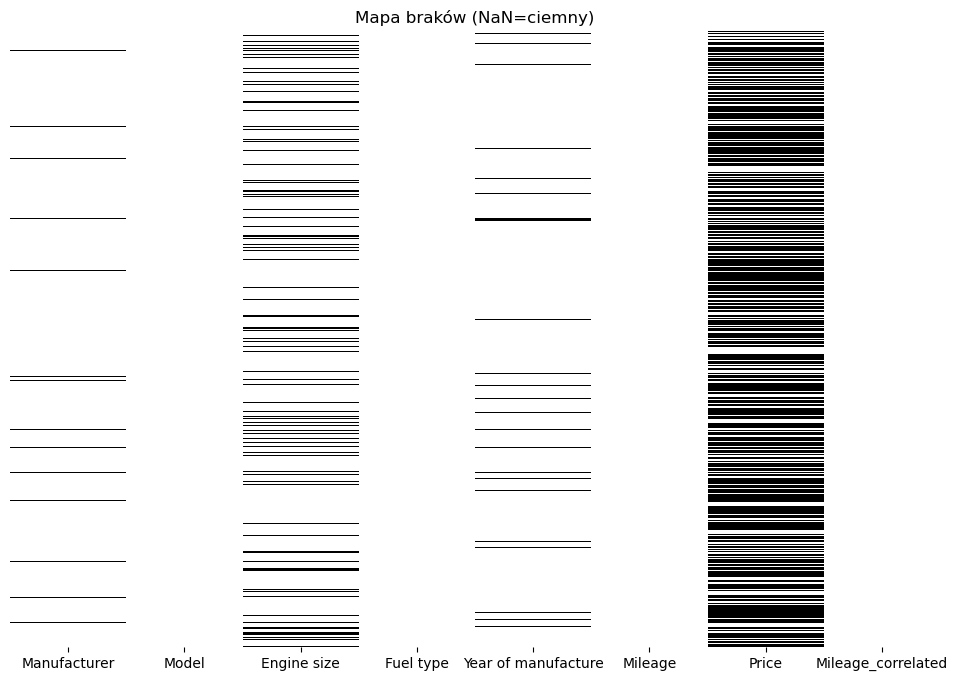

In [12]:
#wizualizacja brakóów
plt.figure(figsize=(12, 8))
sns.heatmap(df_zepsuty.isna(), cbar=False, yticklabels=False, cmap="Greys")  # lub "Reds"
plt.title("Mapa braków (NaN=ciemny)")
plt.show()

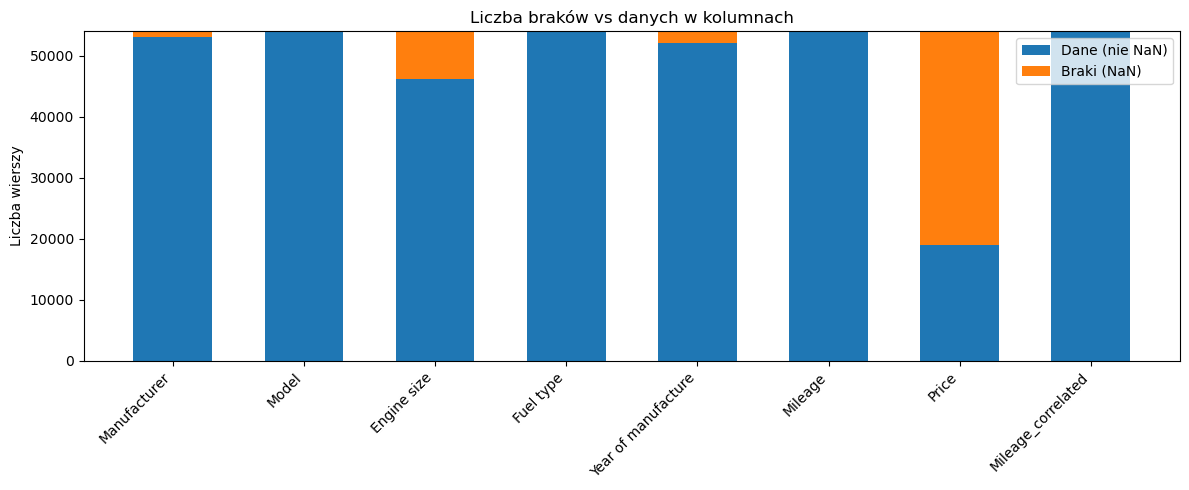

In [13]:
missing_cnt = df_zepsuty.isna().sum()
present_cnt = len(df_zepsuty) - missing_cnt

cols = missing_cnt.index.tolist()
N = len(cols)
ind = np.arange(N)
width = 0.6

plt.figure(figsize=(12, 5))
plt.bar(ind, present_cnt.values, width, label="Dane (nie NaN)")
plt.bar(ind, missing_cnt.values, width, bottom=present_cnt.values, label="Braki (NaN)")
plt.ylabel("Liczba wierszy")
plt.title("Liczba braków vs danych w kolumnach")
plt.xticks(ind, cols, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

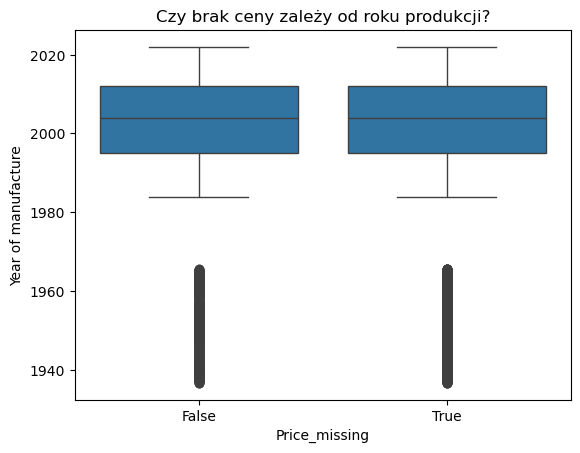

,count,mean,std,min,25%,50%,75%,max
Price_missing,,,,,,,,
False,18329.0,2002.683045,13.292012,1936.734215,1995.0,2004.0,2012.0,2022.0
True,33735.0,2002.501109,13.289147,1936.748342,1995.0,2004.0,2012.0,2022.0


In [14]:
#maska braków dla kolumny
df_missing_flags = df_zepsuty.copy()
for col in df_missing_flags.columns:
    df_missing_flags[f"{col}_missing"] = df_missing_flags[col].isna()

sns.boxplot(x="Price_missing", y="Year of manufacture", data=df_missing_flags)
plt.title("Czy brak ceny zależy od roku produkcji?")
plt.show()

df_missing_flags.groupby("Price_missing")["Year of manufacture"].describe()

#większość braków w tym zbiorze to MCAR (losowe)!!!!

In [15]:
n = len(df_zepsuty)

missing_cnt   = df_zepsuty.isna().sum().rename("missing_cnt")
present_cnt   = (n - missing_cnt).rename("present_cnt")
missing_pct   = (missing_cnt / n * 100).round(2).rename("missing_pct")
present_pct   = (100 - missing_pct).rename("present_pct")
dtypes        = df_zepsuty.dtypes.rename("dtype")

missing_report = (
    pd.concat([missing_cnt, present_cnt, missing_pct, present_pct, dtypes], axis=1)
      .sort_values("missing_pct", ascending=False)
)

missing_report


,missing_cnt,present_cnt,missing_pct,present_pct,dtype
Price,34980,19020,64.78,35.22,float64
Engine size,7886,46114,14.60,85.40,float64
Year of manufacture,1936,52064,3.59,96.41,float64
Manufacturer,900,53100,1.67,98.33,object
Model,0,54000,0.00,100.00,object
Fuel type,0,54000,0.00,100.00,object
Mileage,0,54000,0.00,100.00,float64
Mileage_correlated,0,54000,0.00,100.00,float64


In [16]:
"""CZĘŚĆ 2: Czyszczenie i Naprawa

2.1. Obsługa wartości brakujących:"""


'CZĘŚĆ 2: Czyszczenie i Naprawa\n\n2.1. Obsługa wartości brakujących:'

In [17]:
df_naprawa = df_zepsuty.copy(deep=True)

In [18]:
# kolumny kategoryczne (object, string, category)
cat_cols = df_naprawa.select_dtypes(include=["object", "category", "string"]).columns

for c in cat_cols:
    if df_naprawa[c].isna().any():
        moda = df_naprawa[c].mode(dropna=True)
        if not moda.empty:
            df_naprawa[c] = df_naprawa[c].fillna(moda.iloc[0])

In [19]:
threshold = 0.60
to_drop = df_naprawa.isna().mean()
to_drop = to_drop[to_drop > threshold].index.tolist()
df_naprawa = df_naprawa.drop(columns=to_drop)
print("Usunięto kolumny:", to_drop)

Usunięto kolumny: ['Price']


In [20]:
num_cols = df_naprawa.select_dtypes(include="number").columns

#mediana (odporna na outliery i skośność)
mediany = df_naprawa[num_cols].median(numeric_only=True)
df_median = df_naprawa.copy()
df_median[num_cols] = df_median[num_cols].fillna(mediany)

#średnia (gdy rozkład +-symetryczny)
srednie = df_naprawa[num_cols].mean(numeric_only=True)
df_mean = df_naprawa.copy()
df_mean[num_cols] = df_mean[num_cols].fillna(srednie)

In [21]:
num_cols = df_naprawa.select_dtypes(include="number").columns
mediany = df_naprawa[num_cols].median(numeric_only=True)
df_naprawa[num_cols] = df_naprawa[num_cols].fillna(mediany)

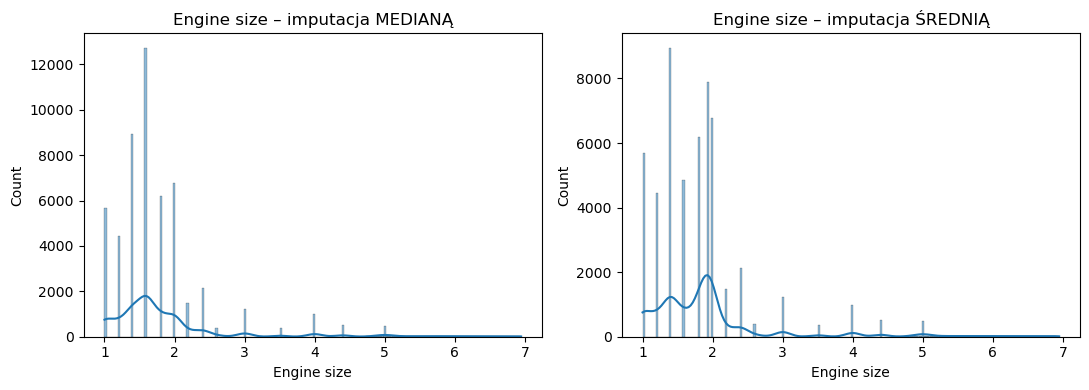

,median
count,54000.000000
mean,1.871830
std,0.976091
min,1.000000
25%,1.400000
50%,1.600000
75%,2.000000
max,6.945603


,mean
count,54000.000000
mean,1.918316
std,0.969596
min,1.000000
25%,1.400000
50%,1.800000
75%,2.000000
max,6.945603


In [22]:
col = "Engine size"
import seaborn as sns, matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(11,4))
sns.histplot(df_median[col], kde=True, ax=ax[0]); ax[0].set_title(f"{col} – imputacja MEDIANĄ")
sns.histplot(df_mean[col],   kde=True, ax=ax[1]); ax[1].set_title(f"{col} – imputacja ŚREDNIĄ")
plt.tight_layout(); plt.show()

display(df_median[col].describe().to_frame("median"), df_mean[col].describe().to_frame("mean"))

In [23]:
df_naprawa.head()

,Manufacturer,Model,Engine size,Fuel type,Year of manufacture,Mileage,Mileage_correlated
0,Toyota,Yaris,1.4,Petrol,2002.0,459833.184564,637570.440019
1,poyota,RAV4,1.6,Petrol,1999.0,214133.000000,-569253.351968
2,VW,Golf,1.8,Diesel,2001.0,152278.000000,57865.811950
3,BMW,X3,2.4,Diesel,2007.0,182103.000000,153502.575227
4,Ford,Fiesta,1.2,Petrol,1997.0,222433.000000,776100.462805


In [24]:
df_naprawa['Year of manufacture'] = pd.to_numeric(df_naprawa['Year of manufacture'], errors='coerce')
df_naprawa['Mileage'] = pd.to_numeric(df_naprawa['Mileage'], errors='coerce')
df_naprawa['Mileage_correlated'] = pd.to_numeric(df_naprawa['Mileage_correlated'], errors='coerce')

#rok produkcji: z float na inta (nullable, jeśli mogą być NaN)
df_naprawa['Year of manufacture'] = df_naprawa['Year of manufacture'].round().astype('Int64')

#przebieg: zaokrąglenie (i ewentualnie rzut do int)
df_naprawa['Mileage'] = df_naprawa['Mileage'].round().astype('Int64')
#pozbycie sie minusowych wartości z ostatniej kolumny
df_naprawa['Mileage_correlated'] = df_naprawa['Mileage_correlated'].abs().round(2).astype('Int64')

print(df_naprawa.dtypes)
df_naprawa.head()

TypeError: cannot safely cast non-equivalent object to int64

In [25]:
df_iqr_report = {}
df_before = df_naprawa.copy()

num_cols = df_before.select_dtypes(include="number").columns

def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

outlier_mask = pd.DataFrame(False, index=df_before.index, columns=num_cols)

for c in num_cols:
    low, high = iqr_bounds(df_before[c].dropna())
    outlier_mask[c] = (df_before[c] < low) | (df_before[c] > high)

#ile outlierów w % per kolumna
outlier_rate = outlier_mask.mean().sort_values(ascending=False)*100
outlier_rate.name = "outlier_pct"
outlier_rate.to_frame().round(2)

,outlier_pct
Engine size,9.64
Mileage,5.32
Year of manufacture,3.0
Mileage_correlated,2.6


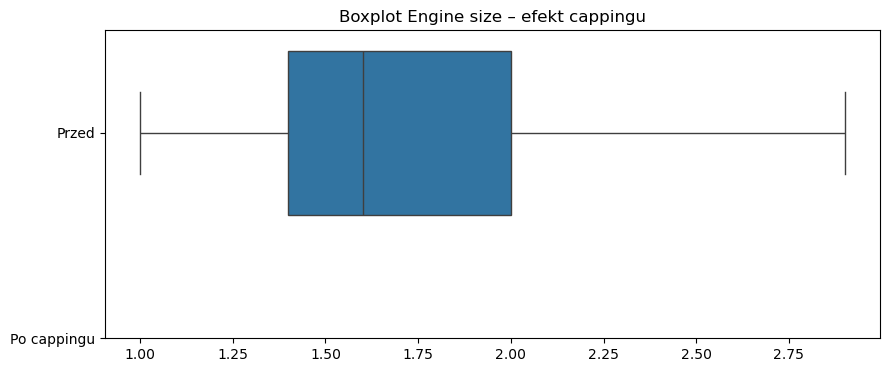

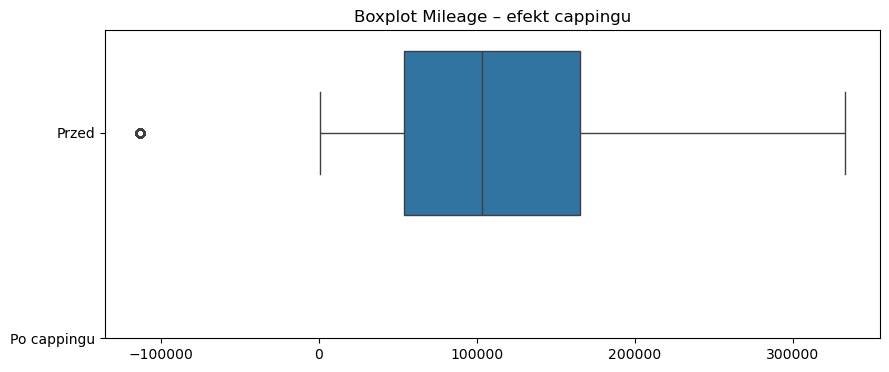

In [26]:
df_capped = df_before.copy()

def cap_iqr(df, cols, k=1.5, non_negative_cols=None, round_int=True):

    if non_negative_cols is None:
        non_negative_cols = []

    for col in cols:
        s = df[col]
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
     
        if col in non_negative_cols:
            lower = max(lower, 0)

        s_float = s.astype("float64").clip(lower=lower, upper=upper)

        if pd.api.types.is_integer_dtype(s.dtype) and round_int:
            df[col] = s_float.round().astype("Int64")
        else:
            df[col] = s_float

    return df

df_capped = cap_iqr(df_capped, outlier_rate.index.tolist())

for col in ["Engine size", "Mileage"]:
    plt.figure(figsize=(10,4))
    sns.boxplot(data=[df_before[col], df_capped[col]], orient="h")
    plt.yticks([0,1], ["Przed", "Po cappingu"])
    plt.title(f"Boxplot {col} – efekt cappingu")
    plt.show()


In [ ]:
df_before_desc = df_naprawa.describe().T
df_after_desc = df_capped.describe().T

comparison = df_before_desc.join(df_after_desc, lsuffix="_before", rsuffix="_after")
comparison[["mean_before", "mean_after", "min_before", "min_after", "max_before", "max_after"]].round(2)

In [27]:
"""2.3. Feature Engineering - utworzyć minimum 1 nową kolumnę:

kolumny powinny logicznie wynikać z istniejących danych
Przykłady: ratio dwóch kolumn, binning zmiennych ciągłych, agregacje, interakcje
Uzasadnienie dlaczego nowe kolumny mogą być wartościowe
Analiza korelacji nowych kolumny z targetem"""

df_capped["Mileage_per_engine"] = (
    df_capped["Mileage"] / df_capped["Engine size"].replace(0, pd.NA)
).round(2)

#binning wieku (wymaga Car_age)
CURRENT_YEAR = 2025
if "Car_age" not in df_capped.columns:
    df_capped["Car_age"] = CURRENT_YEAR - df_capped["Year of manufacture"]

bins   = [0, 5, 10, 20, 40, 200]
labels = ["0-4 lat", "5-9 lat", "10-19 lat", "20-39 lat", "40+ lat"]
df_capped["Age_category"] = pd.cut(df_capped["Car_age"].clip(lower=0), bins=bins, labels=labels, right=False)

# tymczasowy widok do EDA z targetem
df_eda = df_capped.copy()
df_eda["Price"] = df_zepsuty["Price"]#dołączamy kolumnę celu tylko do analizy

mask_known = df_eda["Price"].notna()

#korelacje (tylko numery z Price)
new_numeric = ["Mileage_per_engine", "Car_age"]
corr_new = df_eda.loc[mask_known, new_numeric].corrwith(df_eda.loc[mask_known, "Price"]).sort_values(ascending=False)
print("Korelacja nowych kolumn z Price (na wierszach z ceną):")
print(corr_new)

#średnia cena per kategoria wieku (bo Age_category jest kategoryczne)
price_by_age = df_eda.loc[mask_known].groupby("Age_category")["Price"].mean().round(2)
print("\nŚrednia Price wg Age_category (tylko znane ceny):")
print(price_by_age)

Korelacja nowych kolumn z Price (na wierszach z ceną):
Mileage_per_engine   -0.503225
Car_age              -0.571957
dtype: float64

Średnia Price wg Age_category (tylko znane ceny):
Age_category
0-4 lat      50831.47
5-9 lat      35677.85
10-19 lat    17101.09
20-39 lat     5893.97
40+ lat      10882.63
Name: Price, dtype: float64


C:\Users\artge\AppData\Local\Temp\ipykernel_15696\3633801443.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_age = df_eda.loc[mask_known].groupby("Age_category")["Price"].mean().round(2)


In [28]:
"""CZĘŚĆ 3: Walidacja i Wizualizacja

3.1. Kontrola jakości:

Sprawdzenie i usunięcie duplikatów (z uzasadnieniem metody)
Walidacja zakresów wartości (czy są sensowne dla domeny?)
Test normalności rozkładu dla kluczowych zmiennych numerycznych (Shapiro-Wilk, Q-Q plot)
Sprawdzenie spójności danych między kolumnami"""
#sprawdzenie duplikatów
dupes_count = df_capped.duplicated().sum()
print(f"Liczba zduplikowanych wierszy: {dupes_count}")

if dupes_count > 0:
    df_capped = df_capped.drop_duplicates()
    print("Duplikaty zostały usunięte.")
else:
    print("Brak duplikatów w zbiorze danych.")

Liczba zduplikowanych wierszy: 220
Duplikaty zostały usunięte.


In [29]:
checks = {
    "Year of manufacture": (1900, 2025),
    "Engine size": (0.6, 10),
    "Mileage": (0, 1_000_000),
    "Car_age": (0, 125)
}

for col, (low, high) in checks.items():
    invalid = df_capped[(df_capped[col] < low) | (df_capped[col] > high)]
    print(f"{col}: {len(invalid)} wartości poza zakresem ({low}-{high})")

Year of manufacture: 0 wartości poza zakresem (1900-2025)
Engine size: 0 wartości poza zakresem (0.6-10)
Mileage: 796 wartości poza zakresem (0-1000000)
Car_age: 0 wartości poza zakresem (0-125)



Engine size - stat=0.8972, p=0.0000
Odrzucamy H0 - rozkład różni się od normalnego.


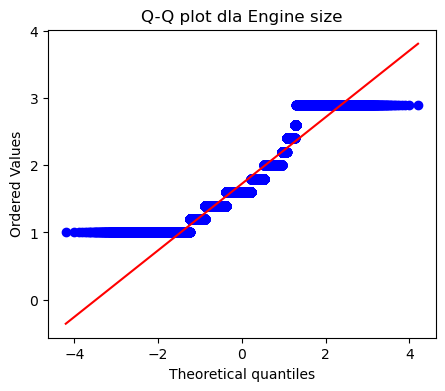

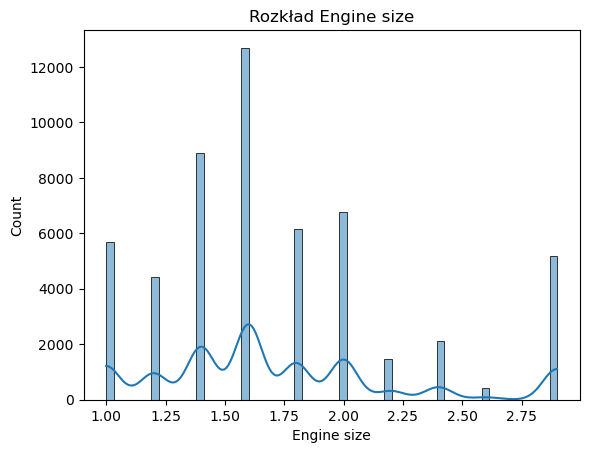


Mileage - stat=0.9538, p=0.0000
Odrzucamy H0 - rozkład różni się od normalnego.


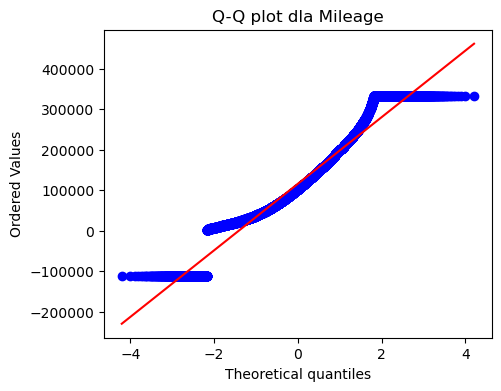

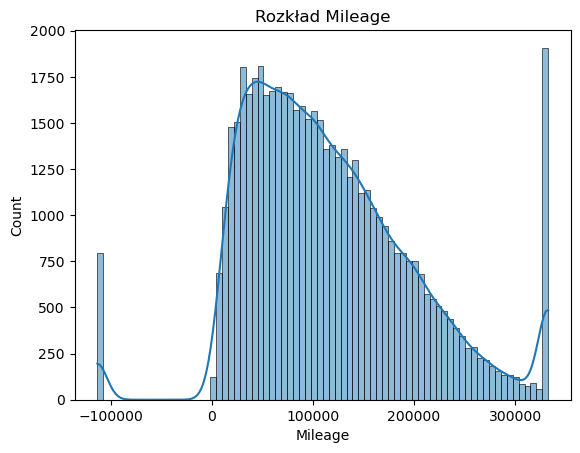


Car_age - stat=0.9619, p=0.0000
Odrzucamy H0 - rozkład różni się od normalnego.


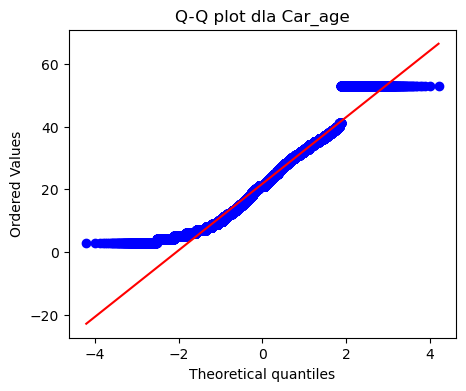

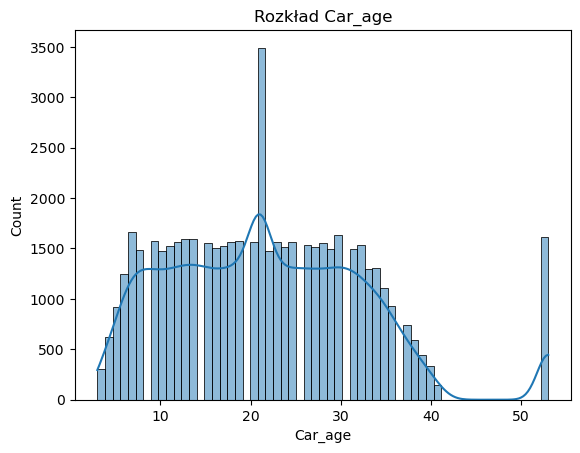

In [30]:
cols_to_test = ["Engine size", "Mileage", "Car_age"]

for col in cols_to_test:
    data = df_capped[col].dropna()
    stat, p = shapiro(data.sample(min(5000, len(data))))
    print(f"\n{col} - stat={stat:.4f}, p={p:.4f}")
    if p < 0.05:
        print("Odrzucamy H0 - rozkład różni się od normalnego.")
    else:
        print("Nie ma podstaw do odrzucenia H0 - rozkład może być normalny.")
    
    # Q-Q plot
    plt.figure(figsize=(5,4))
    probplot(data, dist="norm", plot=plt)
    plt.title(f"Q-Q plot dla {col}")
    plt.show()

    # histogram
    sns.histplot(data, kde=True)
    plt.title(f"Rozkład {col}")
    plt.show()

In [31]:
#wiek jeździdła vs rok prod
check_age = (df_capped["Car_age"] == 2025 - df_capped["Year of manufacture"]).all()
print("Car_age spójne z Year of manufacture:", check_age)

#braki
check_infinite = np.isinf(df_capped.select_dtypes(include="number")).any().any()
print("Brak wartości nieskończonych:", not check_infinite)

if "Mileage_per_year" in df_capped.columns:
    neg_count = (df_capped["Mileage_per_year"] < 0).sum()
    print(f"Liczba ujemnych wartości Mileage_per_year: {neg_count}")

Car_age spójne z Year of manufacture: True
Brak wartości nieskończonych: True


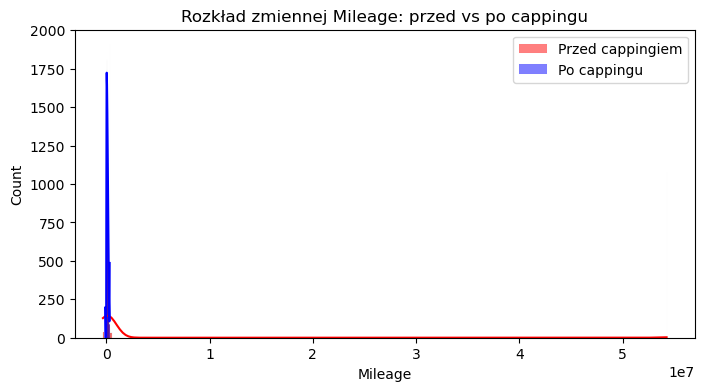

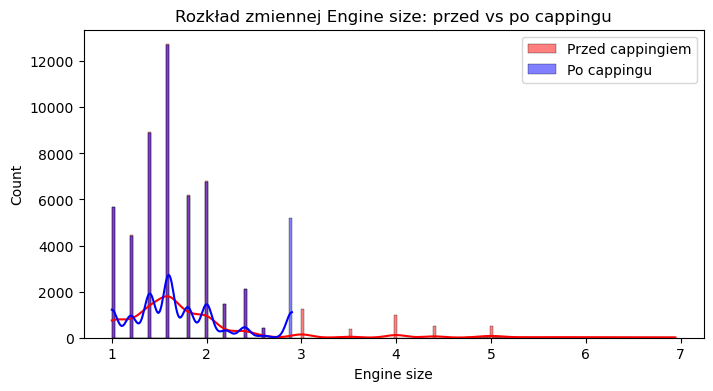

In [32]:
"""3.2. Wizualizacje - wykonać minimum 4 wykresy:

Distribution plot dla najważniejszych zmiennych (przed/po transformacji)
Correlation heatmap (przed/po feature engineering)
Box plot lub violin plot dla wykrywania outlierów
Scatter plot lub pair plot dla relacji między zmiennymi"""
#Distribution plot — rozkłady kluczowych zmiennych (przed i po transformacji)

cols = ["Mileage", "Engine size"]

for col in cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df_naprawa[col], color="red", kde=True, label="Przed cappingiem", alpha=0.5)
    sns.histplot(df_capped[col], color="blue", kde=True, label="Po cappingu", alpha=0.5)
    plt.title(f"Rozkład zmiennej {col}: przed vs po cappingu")
    plt.legend()
    plt.show()

In [ ]:
#Correlation heatmap — korelacje między zmiennymi (po feature engineering)

num_cols = df_capped.select_dtypes(include="number").columns
corr = df_capped[num_cols].corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, cmap="coolwarm", annot=False, center=0)
plt.title("Macierz korelacji po Feature Engineering")
plt.show()

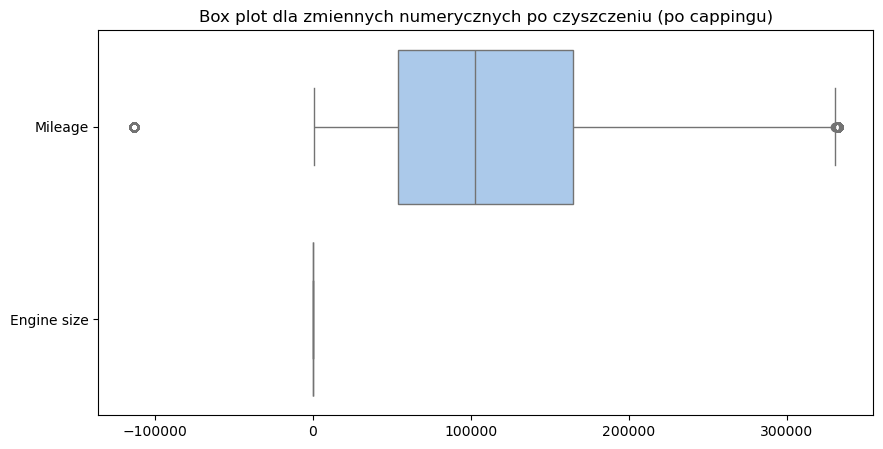

In [33]:
#Box plot wykrywanie i wizualizacja outlierów

plt.figure(figsize=(10,5))
sns.boxplot(data=df_capped[["Mileage", "Engine size"]], orient="h", palette="pastel")
plt.title("Box plot dla zmiennych numerycznych po czyszczeniu (po cappingu)")
plt.show()

In [ ]:
#Scatter plot -  relacje między zmiennymi

df_plot = df_capped.copy()
df_plot["Price"] = df_zepsuty["Price"]

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_plot, x="Car_age", y="Mileage_per_engine", hue="Price",
    palette="coolwarm", alpha=0.6
)
plt.title("Relacja wieku auta i zużycia silnika (kolor = cena)")
plt.xlabel("Car_age (wiek auta)")
plt.ylabel("Mileage_per_engine (zużycie silnika)")
plt.show()